In [1]:
from toolbox.plt_utils import density_scatter
import pandas as pd

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [3]:
# set random seed for reproducibility
from toolbox.utils import set_random_seed
set_random_seed(seed=42)

2025-12-17 15:14:08.033848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-12-17 15:14:08.033880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Validate against lei's chrobmpnet on K562

## 12_17_2025

### How to run

Code changes:
- remove `crop_revcomp_augment` call in `def train_dl` in lei s repo
- `L.seed_everything` w/ the same seed at beginning of both main scripts
- `L.seed_everything` w/ the same seed in ChromBPNet ctor in both repos? (not absolutely necessary but it helps better alignment)

Commands:
```bash
ca hist6

python /home/valehvpa/projects/scCisTrans/histobpnet/scripts/train/main.py \
    --command train \
    --name chrombpnet_train_k562_lei_compare_seed_ev \
    --model_type chrombpnet \
    --output_dir /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/training \
    --fasta /large_storage/goodarzilab/valehvpa/refs/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta \
    --chrom_sizes /large_storage/goodarzilab/valehvpa/refs/hg38/hg38.chrom.sizes \
    --peaks /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/lei_peaks_ss_40000.bed \
    --negatives /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/negatives/lei_negatives_ss_40000.bed \
    --bigwig /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/lei_unstranded.bw \
    --bias_scaled /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/pretrained/ENCSR467RSV/fold_0/model.bias_scaled.fold_0.ENCSR868FGK.h5 \
    --adjust_bias \
    --fold 0 \
    --gpu 0 \
    --cvd 1 \
    --num_workers 8
```

```bash
ca chrombpnetpytorch

chrombpnet train --peaks /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/lei_peaks_ss_40000.bed --negatives /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/negatives/lei_negatives_ss_40000.bed --bigwig /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/lei_unstranded.bw --bias /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/pretrained/ENCSR467RSV/fold_0/model.bias_scaled.fold_0.ENCSR868FGK.h5 --fasta /large_storage/goodarzilab/valehvpa/refs/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta --adjust_bias --num_workers 8
```

### Results

wandb runs:
- chrombpnet_train_k562_lei_compare_seed_ev|instance-20251217_102511
- |27175

We can see that the training curves align quite well 👆

In addition, here are the results from comparing the predictions on the test set from the two trained models.

In [9]:
import pandas as pd
p = "/home/valehvpa/projects/scCisTrans/chrombpnet-pytorch/output/fold_0/predict/test/regions.csv"
lei_df = pd.read_csv(p, sep="\t", header=0)
lei_df

p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/training/instance-20251217_102511/predict/test/regions.csv"
my_df = pd.read_csv(p, sep="\t", header=0)
my_df

,chr,start,end,name,score,strand,signalValue,pValue,qValue,summit,is_peak,peak_id,pred_count,true_count
0,chr3,38003267,38005381,Peak_181021,329,.,1.86632,32.93175,31.00591,1057,1,chr3:38003267-38005381,6.379739,8.300777
1,chr1,226448971,226451085,Peak_113019,787,.,5.3749,78.77083,76.63297,1057,1,chr1:226448971-226451085,6.661883,6.054439
2,chr1,120267010,120269124,Peak_79603,1000,.,4.76701,144.65266,142.34657,1057,1,chr1:120267010-120269124,5.829760,7.218177
3,chr1,151519444,151521558,Peak_212136,248,.,3.28844,24.82766,22.96885,1057,1,chr1:151519444-151521558,6.065908,5.777652
4,chr1,94807230,94809344,Peak_44877,1000,.,12.12747,328.68533,326.09991,1057,1,chr1:94807230-94809344,6.299848,6.551080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,chr3,177686000,177688114,.,.,.,.,.,.,1057,0,chr3:177686000-177688114,6.157891,5.579730
15401,chr1,15060000,15062114,.,.,.,.,.,.,1057,0,chr1:15060000-15062114,6.026216,4.595120
15402,chr6,62683000,62685114,.,.,.,.,.,.,1057,0,chr6:62683000-62685114,6.090096,4.369448
15403,chr6,12961000,12963114,.,.,.,.,.,.,1057,0,chr6:12961000-12963114,5.945041,4.595120


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='mine', ylabel='lei'>,
 array([7.133215 , 5.699716 , 6.2067137, ..., 6.064347 , 6.0615606,
        6.062125 ]),
 array([6.941808 , 5.564716 , 6.3642664, ..., 6.0145864, 6.0128756,
        6.0128455]),
 array([-0.01483382, -0.00996826, -0.00852075, ...,  6.43890369,
         6.43891228,  6.44215091]))

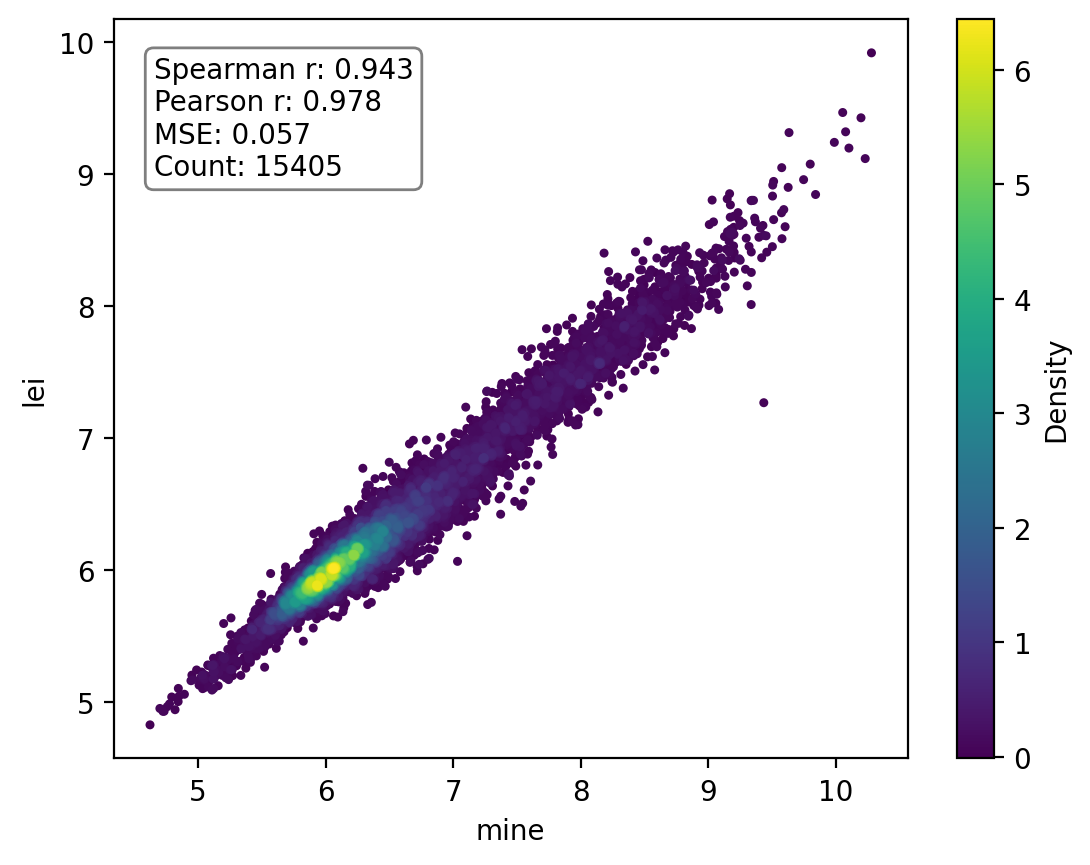

In [11]:
from toolbox.plt_utils import density_scatter
density_scatter(my_df["pred_count"].values, lei_df["pred_count"].values, "mine", "lei", s=5, bins=200, incl_stats=True)

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='mine', ylabel='lei'>,
 array([0.       , 0.       , 0.       , ..., 6.2265368, 6.2265368,
        6.2265368]),
 array([0.       , 0.       , 0.       , ..., 6.2265368, 6.2265368,
        6.2265368]),
 array([0.        , 0.        , 0.        , ..., 7.39962354, 7.39962354,
        7.39962354]))

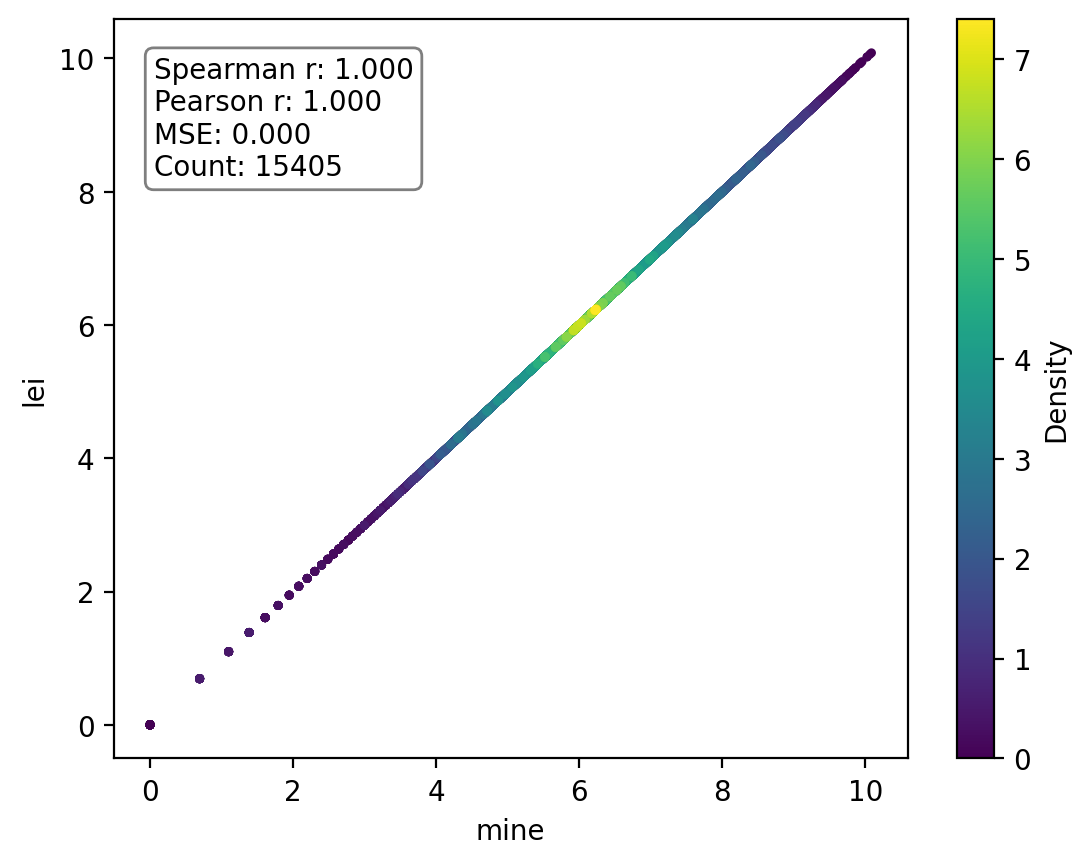

In [12]:
# positive control
density_scatter(my_df["true_count"].values, lei_df["true_count"].values, "mine", "lei", s=5, bins=200, incl_stats=True)

## Ran again

I ran this again on the same day after doing a pretty significant refactor of the data loading and augmentation code to make it more modular and reusable. The results are still quite similar and aligned well.

wandb run (I only re-ran my code since that s where I did the refactor):
- chrombpnet_train_k562_lei_compare_seed_ev|instance-20251217_152811
- old run of my code to which I compare: chrombpnet_train_k562_lei_compare_seed_ev|instance-20251217_102511

Pred comparison results:

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='mine', ylabel='lei'>,
 array([0.       , 0.       , 0.       , ..., 6.2265368, 6.2265368,
        6.2265368]),
 array([0.       , 0.       , 0.       , ..., 6.2265368, 6.2265368,
        6.2265368]),
 array([0.        , 0.        , 0.        , ..., 7.39962354, 7.39962354,
        7.39962354]))

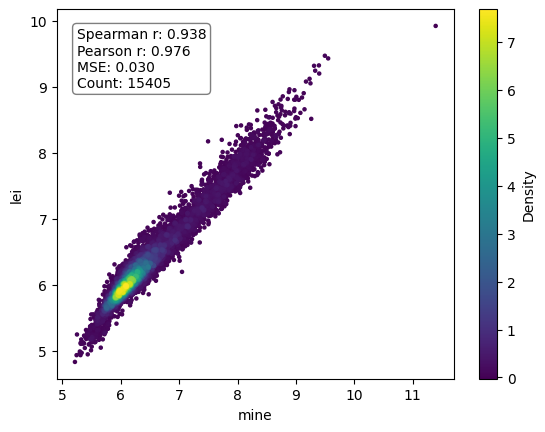

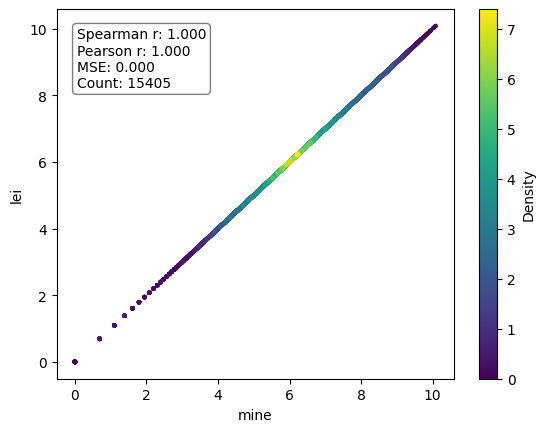

In [2]:
p = "/home/valehvpa/projects/scCisTrans/chrombpnet-pytorch/output/fold_0/predict/test/regions.csv"
lei_df = pd.read_csv(p, sep="\t", header=0)

p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_chrombpnet_tuto/training/instance-20251217_152811/predict/test/regions.csv"
my_df = pd.read_csv(p, sep="\t", header=0)

density_scatter(my_df["pred_count"].values, lei_df["pred_count"].values, "mine", "lei", s=5, bins=200, incl_stats=True)
density_scatter(my_df["true_count"].values, lei_df["true_count"].values, "mine", "lei", s=5, bins=200, incl_stats=True)